# Investigation of the numpy.random package

In [1]:
import numpy as np
import matplotlib.pyplot as pl

## Problem 1: Overall package purpose

## Problem 2: Simple Random Data and Permutations

### numpy.random.rand

Random values in the interval [0, 1)

(array([ 83., 103.,  91., 102.,  92.,  96., 109., 110., 102., 112.]),
 array([2.93483722e-05, 9.99786825e-02, 1.99928017e-01, 2.99877351e-01,
        3.99826685e-01, 4.99776019e-01, 5.99725353e-01, 6.99674687e-01,
        7.99624021e-01, 8.99573355e-01, 9.99522689e-01]),
 <a list of 10 Patch objects>)

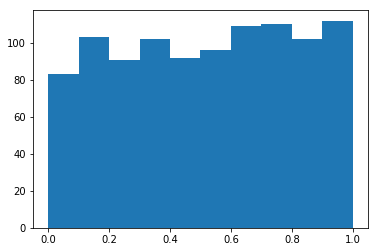

In [2]:
x = np.random.rand(1000)
pl.hist(x)

### numpy.random.randn¶

Random sample of normal/Gaussian distribution

In [3]:
np.random.randn()

0.8157779185273977

In [4]:
2.5 * np.random.randn(2, 4) + 3

array([[ 4.25352379, -1.57914289,  0.22800901,  2.55848315],
       [ 2.15533035,  3.18416051,  2.01742518,  1.31658552]])

### numpy.random.randint
Random integers

In [5]:
np.random.randint(2, size=10)

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 0])

In [6]:
np.random.randint(1, size=10)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [33]:
th = np.random.randint(0, 20, size=(10))
th

array([ 7, 13, 12, 11, 13, 11, 11,  8,  5, 17])

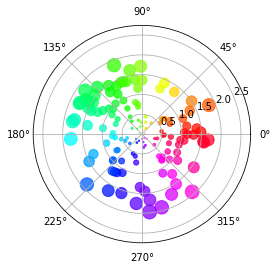

In [35]:
N = 150
r = 2 * np.random.rand(N)
theta = 2 * np.pi * np.random.rand(N)
area = 50 * r**2
colors = theta

fig = pl.figure()
ax = fig.add_subplot(111, projection='polar')
c = ax.scatter(theta, r, c=colors, s=area, cmap='hsv', alpha=0.75)

## Problem 3: Distributions

### Pareto

The 80-20 rule (sociology, economics etc.)

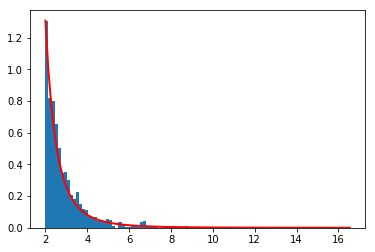

In [37]:
a, m = 3., 2.  # shape and mode
s = (np.random.pareto(a, 1000) + 1) * m
count, bins, _ = pl.hist(s, 100, density=True)
fit = a*m**a / bins**(a+1)
pl.plot(bins, max(count)*fit/max(fit), linewidth=2, color='r')
pl.show()

### Laplace
Laplace transforms for signals

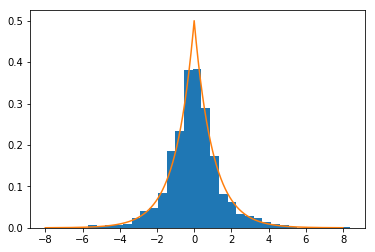

In [38]:
loc, scale = 0., 1.
s = np.random.laplace(loc, scale, 1000)
count, bins, ignored = pl.hist(s, 30, density=True)
x = np.arange(-8., 8., .01)
pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)
pl.plot(x, pdf)